<a href="https://colab.research.google.com/github/E-NAK/Music-Recommendation-System/blob/main/Part_3_Machine_learning_on_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3: Spotify hit prediction round 2!

## Audio features

![Spotify logo](https://drive.google.com/uc?id=1WsaRSK8pVfoEzI0BwZQcXCzhXBfQbI8m)

In this notebook, we'll be building a hit prediction system for the dataset we've been working with; this time, however, we'll be going beyond the metadata and look at the **raw audio** instead!

In [1]:
#@title Run this to download data and prepare the environment. (Restart runtime and rerun cell in case of an error) { display-mode: "form" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# import gdown
import sys

# new dependencies
!pip install requests --upgrade
!pip install urllib3 --upgrade
!pip install spotipy --upgrade
!pip install traces

import spotipy
import requests
from spotipy.oauth2 import SpotifyClientCredentials
import traces

# do not change these codes
client_credentials_manager = SpotifyClientCredentials('e316c18604cb42399f3b679791362112','4bd95a0d37d145998cfdcaf2a68579d7')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# machine learning models
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# audio analysis
import librosa
import librosa.display
!pip install audio2numpy
!apt-get install ffmpeg
import audio2numpy
import IPython.display as ipd

# helper function to plot a timbre timecourse
def plot_timbre(df, song_id, timbre_col):
    col = f'timbre_{timbre_col}'
    plt.figure()
    plt.plot([i*.5 for i in range(len(df[col][song_id]))], df[col][song_id])
    plt.xlabel('time/seconds')
    plt.ylabel('timbre component weight')

# timbre timecourses
# data_url = 'https://drive.google.com/uc?id=1jwG1B98Uq5phurfGmdZg8w2BCJdth6Io'
!wget -O ./spotify_data_timbre.csv = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/spotify_data_timbre.csv'
data_path = './spotify_data_timbre.csv'
# gdown.download(data_url, data_path , True)

# chirp file
# chirp_url = 'https://drive.google.com/uc?id=1iX6wV0cSGIVM0nTItTSUlUehhKCILymB'
!wget -O ./chirp.csv = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/chirp.wav'
chirp_path = './chirp.wav'
# gdown.download(chirp_url, chirp_path , True)

# two wav files
# wav1_url = 'https://drive.google.com/uc?id=14qA48pPVJKU4KlP8YwqTpDo7WEewjXwf'
!wget -O ./wav1_path.csv = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/track_3504.wav'
wav1_path = './sample1.wav'
# gdown.download(wav1_url, wav1_path , True)

# wav2_url = 'https://drive.google.com/uc?id=12XIWhMCAiabzGqXQhN2wB9o5p6MFR4Y0'
!wget -O ./wav2_path.csv = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/track_3642.wav'
wav2_path = './sample2.wav'
# gdown.download(wav2_url, wav2_path , True)

# Check that the data downloaded by running this cell! It'll have more columns than usual.
data = pd.read_csv(data_path)
data.rename(columns={'Unnamed: 0':'orig_index'},inplace=True)
data.drop(columns=['index'],inplace=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=5c17b9983cd695983048cf7e3c89baca573ab282417e4828ed40190f19c82eee
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
--2024-12-22 01:32:19--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2024-12-22 01:32:19--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/spotify_data_timbre.csv
Resolving storage.googleapis.com (storage.goog

## Outline of notebook
Here's what we're going to cover today:
1. Explore some more audio information from Spotify.
2. Machine learning on the timbre timecourses
3. Recurrent Neural Networks (RNNs)


## More audio information
In previous notebooks, we've been considering some pretty abstract features of the songs we're working with, such as **danceability** and **instrumentalness**. While these properties are interesting for sure, they are just single values, so they don't tell you how the music is **changing** over time. For example, a song may be pretty high on the danceability scale, but the beat might only come in part way through after a slower intro.



In [2]:
#@title What other things might the features we've been looking at **not** capture?
your_answer = 'lyrics, composition'  #@param {type:"string"}
print(your_answer)

lyrics, composition


Luckily for us, Spotify has done the hard work and given us twelve **timbre components** which are derived using machine learning from a huge number of audio files. These can be accessed using Spotipy.

For reference, the **timbre** of a sound is its specific quality or characteristic beyond its pitch or pitches.

Here are a couple of videos that explain and demonstrate timbre in a bit more detail.

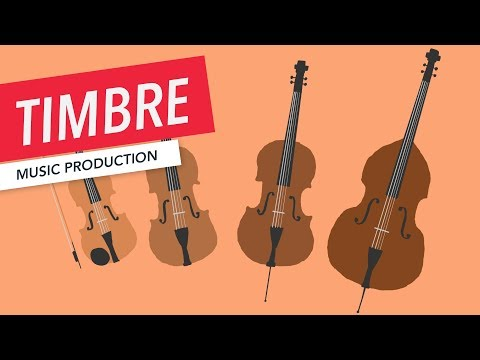

In [3]:
#@markdown  Video 1:
from IPython.display import YouTubeVideo
YouTubeVideo('AjJLAcDb_MU')

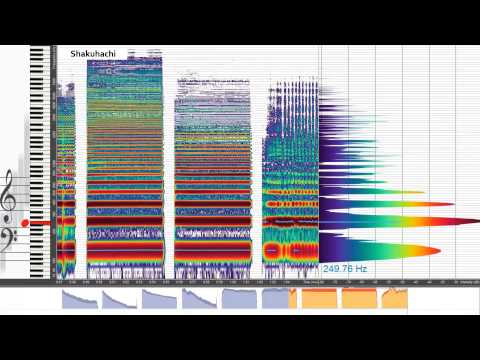

In [ ]:
#@markdown Video 2:
YouTubeVideo('VRAXK4QKJ1Q')

Here's what the timbre components look like:

![timbre basis components](https://drive.google.com/uc?id=1oRc5W4Rc_iwTZ3GpiIrWqswiPTpkfWkx)

It's a little tricky to intepret what they represent, but you can think of them as showing different ways in which the strength of sounds at particular **frequencies** or pitches changes over time. The brighter the colour on the plot, the louder the sound, and the higher up that patch is on the plot, the higher the pitch of the sound that's loud.

So for instance, if a high-pitched flute comes in really loudly part way through a track, you might have a higher value for one of the components that has a lot of loud high frequencies at that point in time. Like component 7 which has a band of bright yellow at the top.

*In later (optional) sections of this notebook, we'll explore a few ways that we might generate some of our own timbre components.*

In [4]:
#@title Which component from the ones above might tell you whether there's a loud **low-pitched** instrument at a particular point in the track?
your_answer = 'Component 2' #@param {type:"string"}
print(your_answer)

Component 2


Now, let's take a look at our timbre data, which is stored in a `pandas` dataframe called `data`. In the code cell below, **write a line that displays the first ten rows of the table**.

In [5]:
### YOUR CODE HERE
data.head(10)

,orig_index,Artist,Track,Year,url,Label,duration,timbre_1,timbre_2,timbre_3,timbre_4,timbre_5,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11,timbre_12
0,0,intonation featuring joee,died in your arms,2009,https://open.spotify.com/track/0AAMVuVqJnW4PVZ...,1,280.160,"[0.0, 31.93096608872048, 35.389407422975076, 3...","[171.13, 79.98731220576416, 75.74027308646127,...","[9.469, 123.5155301412332, 114.41647005170022,...","[-28.48, -14.00211562751177, 11.83176659240889...","[57.491, 99.35745707505646, 90.77753852297087,...","[-50.067, 25.58930474222069, -10.5464018326257...","[14.833, -30.858398706319136, -42.033517170358...","[5.359, -11.803781528686798, -10.8885563028035...","[-27.228, -25.220395644352585, -25.79008238409...","[0.973, 6.293402572051898, -9.005808583077636,...","[-10.64, 14.310292379530752, -1.31420772561052...","[-7.228, -0.02460263329123258, 8.5397953427766..."
1,1,jack johnson,monsoon,2008,https://open.spotify.com/track/7s4qhv3Txiv4oFW...,0,256.813,"[2.998, 19.65953469052869, 12.744096217650963,...","[103.425, -202.65228065227424, -75.61390510948...","[-58.005, -124.09351766576073, -123.3319800928...","[-58.624, -57.981803958771344, 7.4363185136031...","[37.678, 86.39224106456079, 68.92994625082946,...","[-46.392, -52.425471052766525, -51.88967551426...","[-9.681, -13.297634685400748, -26.091938287989...","[1.02, 29.404950515358188, 106.34929794293298,...","[-33.359, -19.202246192502948, -5.323623092236...","[2.376, -3.9448509820009234, -5.94654147312540...","[-5.873, -5.535454386954515, 4.142536828135369...","[-0.558, 6.421904312599354, -3.052210351692103..."
2,2,kapelle herrenweide,humppa,2009,https://open.spotify.com/track/7kZQxHjiHHf6Kqy...,0,258.346,"[1.651, 43.63666528403967, 44.80971266769758, ...","[153.244, 58.93194517583409, 55.15626104400886...","[20.856, -27.760677006311994, -0.9223222719103...","[-68.876, 71.00899765554554, 61.50337614410497...","[46.952, 6.437235166816954, -6.601664479458352...","[-61.662, 51.948587015329124, 15.9049562419024...","[30.292, 30.001814247069433, 25.23144305596188...","[-28.44, -19.782593507664565, -18.267860241568...","[-29.136, -43.0516872858431, -39.7837204831362...","[1.536, 20.711096302975655, -9.602437706356834...","[16.413, -22.591161226330026, -17.839150666610...","[-8.823, 19.360109107303877, 14.08162067956701..."
3,3,2 minutos,rompan todo,2007,https://open.spotify.com/track/4RrFTURDPtSQcbZ...,0,88.586,"[1.093, 51.130689943510035, 52.74655313008504,...","[156.545, 52.262964861328314, 33.7868968714500...","[25.101, 66.05149538824881, 24.51923926192011,...","[-54.729, -50.21109504356429, -9.7744942740474...","[56.904, 0.10991896722305494, -25.195918117343...","[-60.126, -11.785241311077778, -16.25799591661...","[26.202, 31.08373092266939, 32.918958030149525...","[-25.347, 24.86705913892701, 10.52566178502349...","[-30.721, -14.403229598187213, -14.19191108654...","[-4.711, 8.364651230332237, 6.013853673513248,...","[13.125, -10.645196151022883, 2.13488366952197...","[-10.526, -1.9825545910062878, -0.156492094194..."
4,4,sonora carruseles,la chola caderona,2015,https://open.spotify.com/track/4lFHxhQGDhRbfYe...,0,295.306,"[0.0, 38.675149685878175, 50.917856753023614, ...","[171.13, -47.33685659655833, 61.13510342620351...","[9.469, -8.687915596831491, 5.171144089209324,...","[-28.48, 103.47913602840754, -7.81937721928369...","[57.491, 9.400311663479915, -6.473240844928036...","[-50.067, -75.22705845397432, -6.7019374389381...","[14.833, -46.940350996995335, 1.90458376848699...","[5.359, -7.027439770554484, 15.520397466563324...","[-27.228, -21.236274515159792, -7.974969140585...","[0.973, -0.2617473367932267, 3.847741737694988...","[-10.64, -17.457464354001633, 12.9524641040325...","[-7.228, 2.9048615132477447, 18.35614995115049..."
5,5,eddie money,heaven in the back seat,1991,https://open.spotify.com/track/0ZUAwAOJJKtNnkW...,1,243.226,"[0.0, 42.815268714011516, 42.68828631587391, 4...","[171.13, 68.85326007677543, 69.41887799791449,...","[9.469, 5.577371

## Data Transformation
Do you see that there are a bunch of columns called `timbre_1`, `timbre_2` etc.? The entries you see in these columns are basically lists of numbers showing us **how strong** each timbre component is over the first minute or so of each song. A higher value for a particular component means that it's more strongly represented at that point in time.

We can use these pieces of information to do some machine learning!

One thing that's not super obvious from looking at the table is that the lists of numbers are currently formatted as **strings**. This isn't ideal: we need to convert them into the right format. Let's build a function called `string_to_list()` that helps us do this, and test it out on a sample string to see if it works.

A few hints:
1. There's a function called `.split()` which takes a character of your choice and stores the parts of the string separated by that character in a list.
2. We need to make sure that the numbers aren't themselves stored as strings, but rather as **floats**.
3. The square brackets are currently characters, and we don't want to include them when splitting up the string.

In [ ]:
def string_to_list(input_string):
    output_list = []
    #### YOUR CODE HERE ####
    split_var = input_string[1:len(input_string)-1].split(',')
    for i in split_var:
      output_list.append(float(i))
    #### END CODE ####
    return output_list

# some tests to see if your code worked
test_input = '[5, 12.3, 3.3, 9.7]'
print(string_to_list(test_input))
print(type(string_to_list(test_input)))

[5.0, 12.3, 3.3, 9.7]
<class 'list'>


Now, we're going to apply this to each timbre column of the dataset, so that we replace the string with lists. There are 12 components, labelled `timbre_1` to `timbre_12`, so we can use a `for` loop to help us out. The code below achieves what we're after, so go ahead and take a look and then **run this cell**.

In [ ]:
for i in range(1,13): # note we need to go from 1 to 13 since range leaves out the last number
    column = 'timbre_' + str(i)
    if type(data[column][0]) == str: # this means that if we rerun the cell accidentally it won't break!
        data[column] = data[column].apply(string_to_list)

data.head()

,orig_index,Artist,Track,Year,url,Label,duration,timbre_1,timbre_2,timbre_3,timbre_4,timbre_5,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11,timbre_12
0,0,intonation featuring joee,died in your arms,2009,https://open.spotify.com/track/0AAMVuVqJnW4PVZ...,1,280.160,"[0.0, 31.93096608872048, 35.389407422975076, 3...","[171.13, 79.98731220576416, 75.74027308646127,...","[9.469, 123.5155301412332, 114.41647005170022,...","[-28.48, -14.00211562751177, 11.83176659240889...","[57.491, 99.35745707505646, 90.77753852297087,...","[-50.067, 25.58930474222069, -10.5464018326257...","[14.833, -30.858398706319136, -42.033517170358...","[5.359, -11.803781528686798, -10.8885563028035...","[-27.228, -25.220395644352585, -25.79008238409...","[0.973, 6.293402572051898, -9.005808583077636,...","[-10.64, 14.310292379530752, -1.31420772561052...","[-7.228, -0.02460263329123258, 8.5397953427766..."
1,1,jack johnson,monsoon,2008,https://open.spotify.com/track/7s4qhv3Txiv4oFW...,0,256.813,"[2.998, 19.65953469052869, 12.744096217650963,...","[103.425, -202.65228065227424, -75.61390510948...","[-58.005, -124.09351766576073, -123.3319800928...","[-58.624, -57.981803958771344, 7.4363185136031...","[37.678, 86.39224106456079, 68.92994625082946,...","[-46.392, -52.425471052766525, -51.88967551426...","[-9.681, -13.297634685400748, -26.091938287989...","[1.02, 29.404950515358188, 106.34929794293298,...","[-33.359, -19.202246192502948, -5.323623092236...","[2.376, -3.9448509820009234, -5.94654147312540...","[-5.873, -5.535454386954515, 4.142536828135369...","[-0.558, 6.421904312599354, -3.052210351692103..."
2,2,kapelle herrenweide,humppa,2009,https://open.spotify.com/track/7kZQxHjiHHf6Kqy...,0,258.346,"[1.651, 43.63666528403967, 44.80971266769758, ...","[153.244, 58.93194517583409, 55.15626104400886...","[20.856, -27.760677006311994, -0.9223222719103...","[-68.876, 71.00899765554554, 61.50337614410497...","[46.952, 6.437235166816954, -6.601664479458352...","[-61.662, 51.948587015329124, 15.9049562419024...","[30.292, 30.001814247069433, 25.23144305596188...","[-28.44, -19.782593507664565, -18.267860241568...","[-29.136, -43.0516872858431, -39.7837204831362...","[1.536, 20.711096302975655, -9.602437706356834...","[16.413, -22.591161226330026, -17.839150666610...","[-8.823, 19.360109107303877, 14.08162067956701..."
3,3,2 minutos,rompan todo,2007,https://open.spotify.com/track/4RrFTURDPtSQcbZ...,0,88.586,"[1.093, 51.130689943510035, 52.74655313008504,...","[156.545, 52.262964861328314, 33.7868968714500...","[25.101, 66.05149538824881, 24.51923926192011,...","[-54.729, -50.21109504356429, -9.7744942740474...","[56.904, 0.10991896722305494, -25.195918117343...","[-60.126, -11.785241311077778, -16.25799591661...","[26.202, 31.08373092266939, 32.918958030149525...","[-25.347, 24.86705913892701, 10.52566178502349...","[-30.721, -14.403229598187213, -14.19191108654...","[-4.711, 8.364651230332237, 6.013853673513248,...","[13.125, -10.645196151022883, 2.13488366952197...","[-10.526, -1.9825545910062878, -0.156492094194..."
4,4,sonora carruseles,la chola caderona,2015,https://open.spotify.com/track/4lFHxhQGDhRbfYe...,0,295.306,"[0.0, 38.675149685878175, 50.917856753023614, ...","[171.13, -47.33685659655833, 61.13510342620351...","[9.469, -8.687915596831491, 5.171144089209324,...","[-28.48, 103.47913602840754, -7.81937721928369...","[57.491, 9.400311663479915, -6.473240844928036...","[-50.067, -75.22705845397432, -6.7019374389381...","[14.833, -46.940350996995335, 1.90458376848699...","[5.359, -7.027439770554484, 15.520397466563324...","[-27.228, -21.236274515159792, -7.974969140585...","[0.973, -0.2617473367932267, 3.847741737694988...","[-10.64, -17.457464354001633, 12.9524641040325...","[-7.228, 2.9048615132477447, 18.35614995115049..."


The dataframe basically looks the same, but it actually contains lists instead of strings now.

It might be cool to see what some timbre timecourses look like for a particular song. We can use the `plot_timbre` function which takes three parameters: the data, the song index, and the component number.

The code below plots the timbre timecourse of component 3 for the song at index 0 in the dataset.

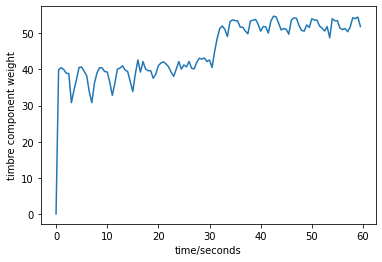

In [ ]:
plot_timbre(data, 100, 1)

Discussion: **How is the timbre component weight changing over time?**

Now **plot 5 different timbre components of your choosing** from a song of your choice (there are 1000 in this dataset, so you can choose between indices 0 and 999). Comment on what you see!

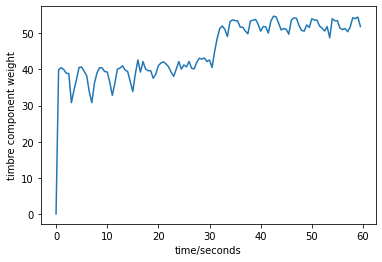

In [ ]:
### YOUR CODE HERE
plot_timbre(data, 100, 1)

Next, we're going to explode the timbre components into their individual timesteps. This will help for our simple machine learning models which can only take **scalar** (single number) values for their features, not lists.

This process will essentially make 120 new columns per timbre component, resulting in 1440 new columns/features. Our new columns will have titles in the format:

> `timbre_{component_number}_{timestep_number}`

where the `component_number` goes from 1 to 12 and the timestep number goes from 0 to 119.

Note that we're not going to drop the old features, just in case we need them later on.

Do this by running the code cell below:

In [ ]:
n_timbres = 12 # this is the number of timbre components
n_timesteps = 120 # this is the number of timesteps we're interested in

for i in range(1,n_timbres+1):
    exploded_cols = []
    for t in range(n_timesteps):
        new_column_title = 'timbre_' + str(i) + '_' + str(t) # this gets us the column title we need
        exploded_cols.append(new_column_title)
    # now, let's generate the new columns
    data[exploded_cols] = pd.DataFrame(data['timbre_' + str(i)].to_list(), index=data.index)

Now that we've done this, let's print out the data set again! **What's different?**

In [ ]:
data.head()

,orig_index,Artist,Track,Year,url,Label,duration,timbre_1,timbre_2,timbre_3,timbre_4,timbre_5,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11,timbre_12,timbre_1_0,timbre_1_1,timbre_1_2,timbre_1_3,timbre_1_4,timbre_1_5,timbre_1_6,timbre_1_7,timbre_1_8,timbre_1_9,timbre_1_10,timbre_1_11,timbre_1_12,timbre_1_13,timbre_1_14,timbre_1_15,timbre_1_16,timbre_1_17,timbre_1_18,timbre_1_19,timbre_1_20,...,timbre_12_80,timbre_12_81,timbre_12_82,timbre_12_83,timbre_12_84,timbre_12_85,timbre_12_86,timbre_12_87,timbre_12_88,timbre_12_89,timbre_12_90,timbre_12_91,timbre_12_92,timbre_12_93,timbre_12_94,timbre_12_95,timbre_12_96,timbre_12_97,timbre_12_98,timbre_12_99,timbre_12_100,timbre_12_101,timbre_12_102,timbre_12_103,timbre_12_104,timbre_12_105,timbre_12_106,timbre_12_107,timbre_12_108,timbre_12_109,timbre_12_110,timbre_12_111,timbre_12_112,timbre_12_113,timbre_12_114,timbre_12_115,timbre_12_116,timbre_12_117,timbre_12_118,timbre_12_119
0,0,intonation featuring joee,died in your arms,2009,https://open.spotify.com/track/0AAMVuVqJnW4PVZ...,1,280.160,"[0.0, 31.93096608872048, 35.389407422975076, 3...","[171.13, 79.98731220576416, 75.74027308646127,...","[9.469, 123.5155301412332, 114.41647005170022,...","[-28.48, -14.00211562751177, 11.83176659240889...","[57.491, 99.35745707505646, 90.77753852297087,...","[-50.067, 25.58930474222069, -10.5464018326257...","[14.833, -30.858398706319136, -42.033517170358...","[5.359, -11.803781528686798, -10.8885563028035...","[-27.228, -25.220395644352585, -25.79008238409...","[0.973, 6.293402572051898, -9.005808583077636,...","[-10.64, 14.310292379530752, -1.31420772561052...","[-7.228, -0.02460263329123258, 8.5397953427766...",0.000,31.930966,35.389407,34.433385,35.126375,35.399419,35.194538,34.525378,34.600585,33.388889,34.024806,33.745943,32.731986,34.877908,33.252572,36.322116,42.196747,40.223044,41.915327,42.890016,41.750908,...,-4.273888,-34.565482,-8.235569,-15.656260,-13.511761,5.164086,-7.861763,5.267805,-10.483580,13.762450,7.311089,5.993696,-5.311188,11.303002,-12.276176,18.834503,-14.299174,2.587736,-17.527357,-9.163650,-11.318990,0.387244,-4.926046,10.569836,26.825443,-0.244880,-6.196952,1.647113,7.159354,-9.104946,5.747648,-9.033312,-6.249918,-2.200340,-23.149632,-24.397224,15.664995,-7.425312,-4.848591,0.929415
1,1,jack johnson,monsoon,2008,https://open.spotify.com/track/7s4qhv3Txiv4oFW...,0,256.813,"[2.998, 19.65953469052869, 12.744096217650963,...","[103.425, -202.65228065227424, -75.61390510948...","[-58.005, -124.09351766576073, -123.3319800928...","[-58.624, -57.981803958771344, 7.4363185136031...","[37.678, 86.39224106456079, 68.92994625082946,...","[-46.392, -52.425471052766525, -51.88967551426...","[-9.681, -13.297634685400748, -26.091938287989...","[1.02, 29.404950515358188, 106.34929794293298,...","[-33.359, -19.202246192502948, -5.323623092236...","[2.376, -3.9448509820009234, -5.94654147312540...","[-5.873, -5.535454386954515, 4.142536828135369...","[-0.558, 6.421904312599354, -3.052210351692103...",2.998,19.659535,12.744096,21.247525,17.446981,16.142592,12.572578,21.125700,12.453884,21.534422,19.931958,14.459355,10.758837,20.974519,16.334699,12.580263,18.889711,15.107504,12.580834,16.022694,20.142797,...,-7.759943,-3.198835,-10.677087,-1.941363,7.731469,-14.802824,-11.663507,-0.747234,-16.634769,-5.982988,-7.184963,-11.034984,-19.214884,10.513084,-4.664986,-19.028684,-20.474207,-17.560453,-20.173121,-8.575428,-15.146911,-5.160070,-0.348717,-14.456230,1.019078,-10.222426,26.266481,4.766826,4.383606,-14.221324,3.791805,-5.079529,-8.855646,-10.307518,10.689436,6.177778,-15.560173,-2.890256,6.928514,-10.078932
2,2,kapelle herrenweide,humppa,2009,https://open.spotify.com/track/7kZQxHjiHHf6Kqy...,0,258.346,"[1.651, 43.63666528403967, 44.80971266769758, ...","[153.244, 58.93194517583409, 55.15626104400886...","[20.856, -27.760677006311994, -0.9223222719103...","[-68.876, 71.00899765554554, 61.50337614410497...","[46.952, 6.437235166816954, -6.601664479458352...","[-61.662, 51.948

For some reason, a few songs did not have 120 timesteps. This means there are some values in our table that are **null** or non-existent. What we're going to do, then, is figure out how many songs don't have 120 timesteps and then drop them from our dataset.

Write some code that generates a list of where those songs are and drops those rows from our dataframe.

Hints:
1. You only need to use **one** timbre component to check which songs aren't long enough. So, for instance, you could just check the values in column `timbre_1_119`, which is the last timestep of timbre component 1.
2. The function `.isnull()` will help you generate a list of boolean values to tell you whether something is null (`True`) or not (`False`).
3. The function `np.where()` takes a list and returns a nested list telling you where the values are `True`. Note that because it returns a **nested list**, you will need to extract the element at index 0 of this output to get a regular list.
4. `data.drop(index=your_rows,inplace=True)` will remove the rows you identified as having null timesteps from your dataframe.

In [ ]:
### YOUR CODE HERE
null_indices = np.where(data['timbre_1_119'].isnull())[0]
data.drop(index=null_indices,inplace=True)

In [ ]:
data.shape

(1000, 1459)

In [ ]:
#@title Given that there were originally 1000 rows in your dataframe, how many were dropped? You may need to write a line of code to work this out.
your_answer =  48#@param {type:"number"}
if your_answer == 48:
    print('Correct! We dropped 48 rows')
else:
    print('Incorrect -- double check your code.')

In [ ]:
### optional code cell to use!


## Machine learning on timbre timecourses

We've done a lot of good work up until this point to get our data ready for some machine learning! What we're going to do now is use the timbre component values at each timestep in our new columns to train five basic models to predict hits. Note that, as with notebook 1, we have a column called `Label` that tells us whether a song was a hit (1) or not (0).

Let's try five basic models to see how well they predict hits:
1. Logistic regression
2. Support vector classifier
3. K-nearest neighbours
4. Gaussian Naive Bayes
5. Multi-layer perceptron (simple neural network)

Your tasks are:
1. Get X (the 1440 features we made) and y (the label) from the dataframe.
2. Split up the dataset into train and test data, using a random state of 1 and 20% of data in testing.
3. Run the models above and get their scores on the test data.
4. Plot the scores in a bar graph.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

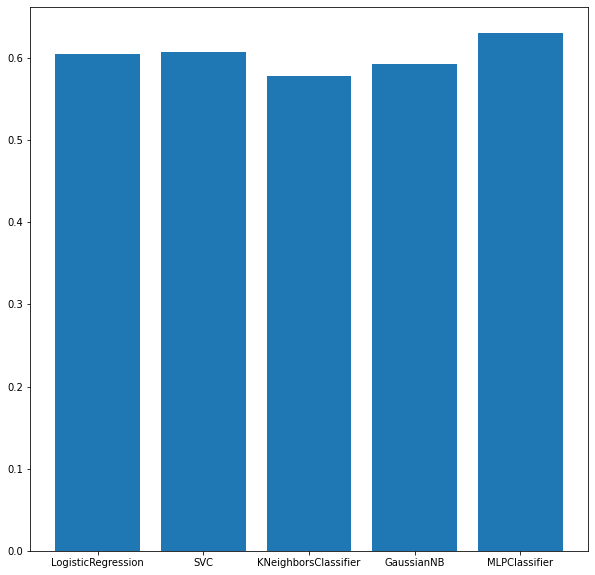

In [ ]:
timbre_cols = [f'timbre_{i}_{j}' for i in range(1,n_timbres+1) for j in range(1,n_timesteps)]

### TODO: Modify this code
X = data[timbre_cols]
y = data[['Label']]

# TODO: add your train/test split code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)


models = [LogisticRegression(), SVC(), KNeighborsClassifier(), GaussianNB(), MLPClassifier(hidden_layer_sizes=(100,10))]
model_names = [type(model).__name__ for model in models]

model_scores = []

### TODO: Modify this code
for model in models:
  model.fit(X_train, y_train)
  model.score(X_test, y_test)
  score = model.score(X_test, y_test)
  model_scores.append(score)

plt.figure(figsize=(10,10))
plt.bar(model_names, model_scores)
plt.show()


In [ ]:
#@title How did these models do? Why do you think they performed this way?
your_answer = '' #@param {type:"string"}

Cool, we were able to train a couple of different models! If you want, move on to the next optional section to try a different type of model.

## Optional Bonus: RNNs with LSTM cells
Since we're dealing with time-series data, it might be beneficial to use **RNNs** (recurrent neural networks). Even better, we can use **LSTM cells** which help with identifying long-term structure in the input. Here's what a regular RNN looks like:


![RNN](https://drive.google.com/uc?id=1cXbEHSfZXq0q_BuYU9SUGZmdDRR0Ox3e)


## Discussion

*   If we're using RNNs on our song data, what are our inputs and outputs?
*   Why might using an RNN be useful to analyze our music data?
*   How does an RNN or LSTM help with identifying long-term structure in the input?



In a recurrent network like this, our **outputs** ($o$) will be scalar/single number values that'll essentially be a prediction of whether a song is a hit or not.

Let's think a bit more carefully about what our RNN **inputs** will be. You can see from the diagram above that we have a certain number of inputs, each marked $x^{(t)}$ where $t$ is a timestep. These $\large{x}\,$s are basically vectors of features.

In our case, our features are the values of the timbre components. So ideally what we want is to get one vector of **12 timbres** for each timestep for each song. Right now, we have it the other way round: we have vectors of **120 timesteps** for each timbre component individually for each song.

The code below swaps the dimensions of our original lists around so that they're vectors of timbres rather than vectors of timesteps, and stores it in a new matrix called `X_new`. The code below is a little involved and takes a few seconds to run, but your instructor will help you understand it!

In [ ]:
cols = ['timbre_' + str(i) for i in range(1,n_timbres+1)]
all_songs = []
for s in range(len(data)): # for every song in the dataframe
    song_timbre_vectors = []
    for t in range(n_timesteps): # for each timestep
        # let's now make a list of the timbre components for song s at timestep t
        time_t_timbres = [data[col].iloc[s][t] for col in cols]
        # now let's add it to our song_timbre_vectors_list
        song_timbre_vectors.append(time_t_timbres)
    # now let's add that song's timbre vectors to the all_songs list
    all_songs.append(song_timbre_vectors)

# finally, convert this to a matrix.
X_new = np.array(all_songs)

Let's now look at the dimensions of X_new.

In [ ]:
print(X_new.shape)

(952, 120, 12)


In [ ]:
#@title What do the dimensions represent?
dim1 = "number of songs" #@param {type:"string"}
dim2 = "time steps " #@param {type:"string"}
dim3 = 'timbre' #@param {type:"string"}

print(f'{X_new.shape[0]} is {dim1}')
print(f'{X_new.shape[1]} is {dim2}')
print(f'{X_new.shape[2]} is {dim3}')

Let's also ensure that we make `y_new` from y, as a numpy array with the length equivalent to the number of examples.

In [ ]:
y_new = np.array(y)
y_new.shape

(952, 1)

Let's do one final import!

In [ ]:
#@title Final import!
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import BinaryCrossentropy

Now let's build the LSTM model. There are a few things you'll need to do:

1. Specify the number of timesteps, the size of the input and the size of the output.
2. Decide how big the immediate output of the LSTM should be.
3. Decide how many neurons you want in your dense (fully connected) layer after the LSTM layer.
4. Decide if you want to add more layers to your model!


In [ ]:
# Build the model
## TODO: fill in the dimension sizes here
n_timesteps = 120
n_input = 12
n_output = 1

model = Sequential()
## TODO: Choose the number of neurons in the LSTM output.
model.add(LSTM(4, input_shape=(n_timesteps,n_input)))
## TODO: Choose the number of units in your dense hidden layer
model.add(Dense(6))
# Do you want more layers? Add them here!

# Leave this one in
model.add(Dense(n_output))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 272       
_________________________________________________________________
dense (Dense)                (None, 6)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 309
Trainable params: 309
Non-trainable params: 0
_________________________________________________________________


Finally, let's train it!

In [ ]:
# new train-test split
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size=.2, random_state=1)

model.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)

model.fit(
    X_new_train, y_new_train, validation_data=(X_new_test, y_new_test), batch_size=50, epochs=30
)

Epoch 1/30
16/16 [==============================] - 3s 71ms/step - loss: 0.6036 - accuracy: 0.6508 - val_loss: 0.7466 - val_accuracy: 0.5707
Epoch 2/30
16/16 [==============================] - 1s 34ms/step - loss: 0.6042 - accuracy: 0.6464 - val_loss: 0.7475 - val_accuracy: 0.5707
Epoch 3/30
16/16 [==============================] - 1s 34ms/step - loss: 0.6154 - accuracy: 0.6375 - val_loss: 0.7488 - val_accuracy: 0.5707
Epoch 4/30
16/16 [==============================] - 1s 35ms/step - loss: 0.5910 - accuracy: 0.6698 - val_loss: 0.7503 - val_accuracy: 0.5707
Epoch 5/30
16/16 [==============================] - 1s 35ms/step - loss: 0.6212 - accuracy: 0.6471 - val_loss: 0.7500 - val_accuracy: 0.5707
Epoch 6/30
16/16 [==============================] - 1s 35ms/step - loss: 0.6133 - accuracy: 0.6498 - val_loss: 0.7514 - val_accuracy: 0.5654
Epoch 7/30
16/16 [==============================] - 1s 34ms/step - loss: 0.6086 - accuracy: 0.6459 - val_loss: 0.7534 - val_accuracy: 0.5759
Epoch 8/30
16

**Question**: how did this model do compared to the others? What benefits and drawbacks are there to the LSTM model?

In [ ]:
#@title **Question**: how did this model do compared to the others? What benefits and drawbacks are there to the LSTM model?
your_answer = '' #@param {type:"string"}
print(your_answer)

## Congrats on building your models!
Well done for getting through the notebook so far! This isn't an easy one and you've learned a lot already.

In the optional next notebook, you'll have the chance to take a look at more music analysis using spectrograms and principal components analysis. This stuff is pretty challenging, so if you have time go ahead and give it a try!